<a href="https://colab.research.google.com/github/SelenaNahra/MachineLearning/blob/main/ML_Report_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/150], Loss: 0.3063
Epoch [2/150], Loss: 0.3818
Epoch [3/150], Loss: 0.3461
Epoch [4/150], Loss: 0.2010
Epoch [5/150], Loss: 0.1931
Epoch [6/150], Loss: 0.1778
Epoch [7/150], Loss: 0.1230
Epoch [8/150], Loss: 0.3923
Epoch [9/150], Loss: 0.5140
Epoch [10/150], Loss: 0.1954
Epoch [11/150], Loss: 0.2628
Epoch [12/150], Loss: 0.2468
Epoch [13/150], Loss: 0.2203
Epoch [14/150], Loss: 0.1945
Epoch [15/150], Loss: 0.3956
Epoch [16/150], Loss: 0.1508
Epoch [17/150], Loss: 0.1510
Epoch [18/150], Loss: 0.2043
Epoch [19/150], Loss: 0.1116
Epoch [20/150], Loss: 0.3483
Epoch [21/150], Loss: 0.1534
Epoch [22/150], Loss: 0.3989
Epoch [23/150], Loss: 0.2535
Epoch [24/150], Loss: 0.3444
Epoch [25/150], Loss: 0.3243
Epoch [26/150], Loss: 0.2761
Epoch [27/150], Loss: 0.1737
Epoch [28/150], Loss: 0.1600
Epoch [29/150], Loss: 0.2470
Epoch [30/150], Loss: 0.2703
Epoch [31/150], Loss: 0.1386
Epoch [32/150], Loss: 0.2208
Epoch [33/150], Loss: 0.1677
Epoch [34/150], Loss: 0.1817
Epoch [35/150], Loss: 0

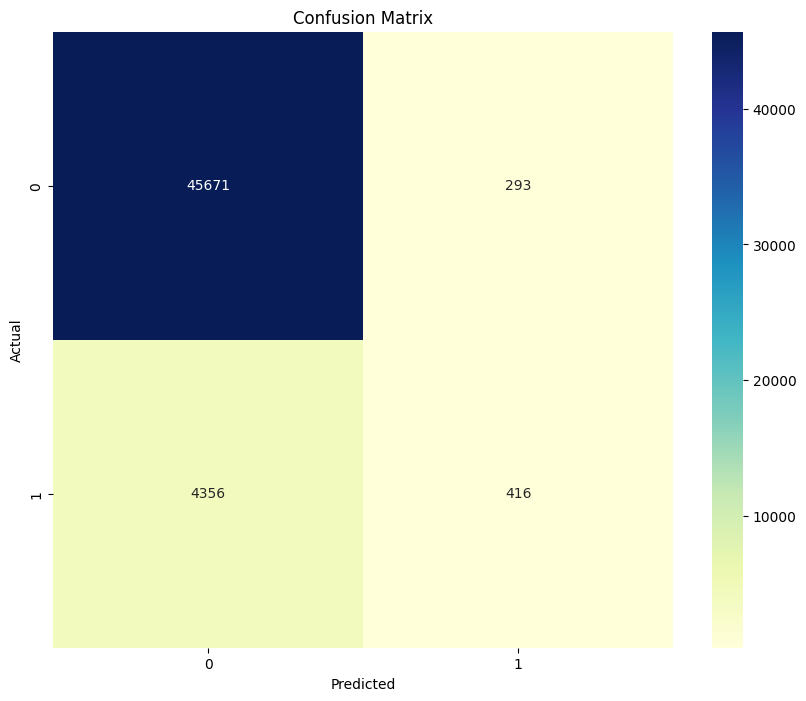

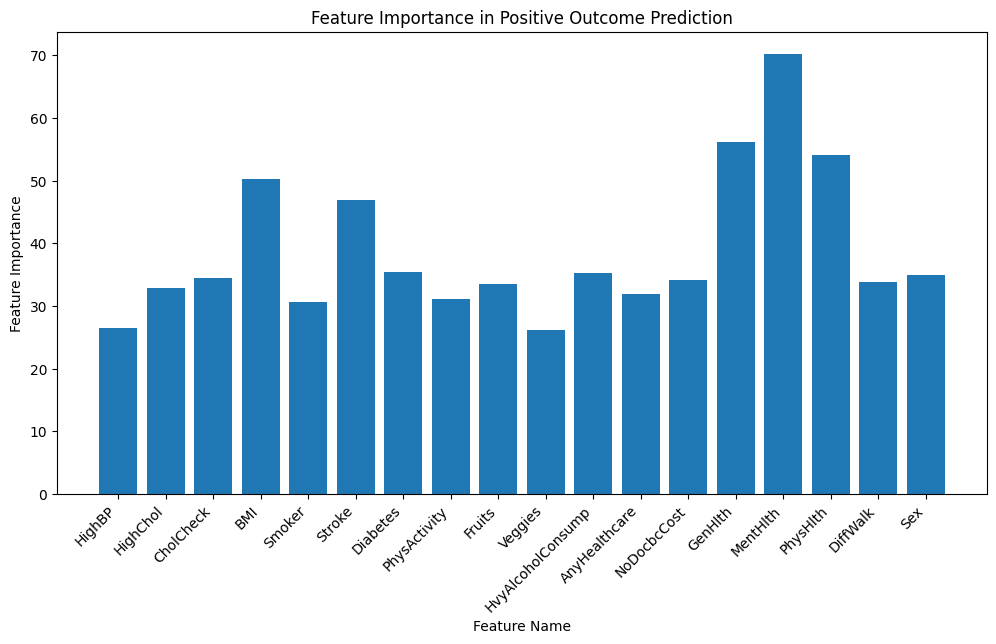

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import the dataset
data = pd.read_csv("Project DataSet.csv")

x = data.iloc[:, 1:19].values
y = data.iloc[:, 0].values

column_to_modify1 = 'BMI'

# Change BMI: 1 = Obseity, 0 = Not Obese
data[column_to_modify1] = data[column_to_modify1].apply(lambda x: 1 if x >= 30 else 0)

column_to_modify2 = 'Diabetes'

# Change Diabetes: 1 = Type 1 or Type 2, 0 = Not Diabetic
data[column_to_modify2] = data[column_to_modify2].apply(lambda x: 1 if x >= 1 else 0)

# Convert to float before normalization
x = x.astype('float64')
y = y.astype('int64')

# Normalize features
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)

# Convert to PyTorch tensors
tensor_x = torch.tensor(x_normalized, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.long)

# Separate training and validation sets
x_train, x_test, y_train, y_test = train_test_split(tensor_x, tensor_y, test_size=0.20, random_state=0)

# Define FCNN model
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = x_train.shape[1]  # Number of features
hidden_size = 64
output_size = 5  # Number of classes

batch_size = 32
learning_rate = 0.001
num_epochs = 150

# Model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFCNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation loop
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
f1 = f1_score(all_labels, all_predicted, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

learned_weights = model.fc1.weight.detach().cpu().numpy()

feature_names = data.columns[1:19]

feature_importance = np.abs(learned_weights).sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Positive Outcome Prediction')
plt.show()